# [Multilevel Modeling](https://en.wikipedia.org/wiki/Multilevel_model)
Idea: Decompose the sum of random numbers into its contributions

for a given set of $x_i$ and $a_{ik}$ with
$$x_i = \Sigma_{j=0}^n \Sigma_{k=1}^{m_j} a_{ik}y_{jk}$$ 
with
* $m_j$ being the number of contributers of layer j
* $y_{jk}$ being the k-th contribution of layer j
* $m_0 = 1$ by default
* $a_{ik} \in \{0, 1\}$
* $\Sigma a_{ik} = 1$ only one contributer per layer

calculate the Distributions $y_{k} \sim N(μ_{k}, σ_{k})$
Boundary conditions:
* $\Sigma _{k} μ_k = 0$ via $μ_{m_j} = -\Sigma_{k = 1}^{m_j-1} μ_{k}$

In [186]:
import numpy as np
#import os
import warnings
import matplotlib.pyplot as plt
import logging
import seaborn as sns
import pymc as pm
import arviz as az
import pytensor as pt
#import pandas as pd
#import pymc.sampling_jax as sampling_jax
import nutpie

%matplotlib inline
plt.style.use('default')

#logging.basicConfig(format='%(message)s', level=logging.INFO)
warnings.filterwarnings("ignore", module="scipy")

In [ ]:

pm.math.sum

In [2]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.16.2


## Initialize the data

In [82]:
n_samples = 10000

## setup the individual random generators

In [166]:
def align_coefficients(coefs):
    """ensure that the average over all contributers per level is 0"""
    mem = []
    for level, lcoefs in enumerate(coefs):
        avg = np.mean([m for (m, s) in lcoefs.values()])
        mem.append({k: (m-avg, s) for k, (m,s) in lcoefs.items()})
    
    return mem

def gen_contributer_coefficients(n_contributers, contributer_avg, contributer_sig):
    """creates for n_contributers the average and standard deviation
    Input:
    * n_contributers: list with number of influencers for each level
    * contributer_avg: average for the average of the influencers
    * contributer_sig: average for the stdev for the influencers (lognormal distribution) 
     
    Output:
    Dictionary {level : { influencer: (mu, sigma)}} with the coefficients for every
    influencer in each level
    """
    assert n_contributers[0] == 1, "First level is allowed to have one contributer"
    return align_coefficients([{i : (np.random.normal(contributer_avg), np.random.lognormal(contributer_sig)) for i in range(num)} for lvl, num in enumerate(n_contributers)])

def print_coefficients(contributer_coefficients):
    contributer_coefficients = align_coefficients(contributer_coefficients)
    for m, stage in enumerate(contributer_coefficients):
        for i, (mu, sig) in stage.items():
            print(f"Stage {m}: Contributer {i} mu={mu:.2f}, sig={sig:.2f}")

In [127]:
# easy as a start

cc_12 = [
    {    0 : (0, 5)},
    {    0: (1, 1),
        1: (-1, 1)}
        ]
cc_22 = [
    {    0 : (0, 5)},
    {    0: (1, 1),
        1: (-1, 1)},
    {    0: (1, 1),
        1: (-1, 1)}
        ]
cc_14 = [{    0: (0, 5)},
        {    0: (0, 1),
                1: (0, 1),
                2: (0, 1),
                3: (4, 2)}]
cc_343 = [{    0: (0, 5)},
        {    0: (0, 1),
                1: (0, 1),
                2: (0, 1),
                3: (4, 2)},
            {    0: (0, 1),
                1: (0, 1),
                3: (3, 2)}]

In [115]:
print_coefficients(cc_343)

Stage 0: Contributer 0 mu=0.00, sig=5.00
Stage 1: Contributer 0 mu=-1.00, sig=1.00
Stage 1: Contributer 1 mu=-1.00, sig=1.00
Stage 1: Contributer 2 mu=-1.00, sig=1.00
Stage 1: Contributer 3 mu=3.00, sig=2.00
Stage 2: Contributer 0 mu=-1.00, sig=1.00
Stage 2: Contributer 1 mu=-1.00, sig=1.00
Stage 2: Contributer 3 mu=2.00, sig=2.00


## Create the Data

In [116]:
def gen_data(contributer_coefficients, n_samples):
    """generate random data.
    The first level defines the baseline that holds for all random numbers
    
    Inputs:
    * n_samples: number of samples
    * contributer_coefficients: dictionary with (mean,sig) per level per contributer
    
    Outputs:
    * data: array with the final number
    * contributers: matrix defining the contributers, first column is for the first level"""
    
    assert len(contributer_coefficients[0]) == 1, "Level 0 defines the baseline. It should have exactly one contributer"
    #data = np.random.normal(gen_avg, gen_sig, n_samples)
    data = np.zeros((n_samples, ))
    contributers = np.zeros((n_samples, len(contributer_coefficients)))
    for lvl, cdict in enumerate(contributer_coefficients):
        print(f"creating level {lvl}")
        lvl_influencers = len(cdict) #number of influencers in this level
        lvldata = np.zeros((n_samples, lvl_influencers))

        for i, (mu,sig) in cdict.items():
            lvldata[:,i] = np.random.normal(mu, sig, n_samples)

        selection = np.random.randint(low=0,
                                    high=lvl_influencers,
                                    size=(n_samples))
        contributers[:, lvl] = selection
        
        data += np.array([lvldata[row, col] for row, col in enumerate(selection)])
        # Note: The first level 
    return data, contributers[:, 1:].astype(int)

# Modeling

use [Radon Analysis](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/multilevel_modeling.html) as reference

In [158]:
def generate(n_samples, contributer_coefficients):
    if contributer_coefficients == 2:
        n_contributers= len(contributer_coefficients[1])
        print("ATTENTION: just for one level")
    else:
        n_contributers = [len(level) for level in contributer_coefficients][1:]

    data, contributers = gen_data(n_samples=n_samples,
                              contributer_coefficients=contributer_coefficients)

    #contributers = contributers.squeeze(-1) # kill the first level - not needed
    return data, contributers, n_contributers

In [170]:
# generate the data
data0, contributers0, n_contributers0 = generate(n_samples=n_samples, contributer_coefficients=cc_14)
data, contributers, n_contributers = generate(n_samples=n_samples, contributer_coefficients=cc_22)

contributers0 = contributers0.squeeze(-1) # for the 1 level version
n_contributers0 = n_contributers0[0]

creating level 0
creating level 1
creating level 0
creating level 1
creating level 2


In [11]:
with pm.Model() as model0:
    assert type(n_contributers0) is int, "only one level is possible"
    contributer_data_idx = pm.ConstantData("contributer_data_idx", contributers0, dims="obs_id")
    #datam = pm.ConstantData("data_idx", data0, dims="obs_id")

    # Priors
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=10)
    a_sigma = pm.Exponential("a_sigma", 1)

    # contributions
    con_sigmas = pm.Exponential("con_sigmas", 1, shape=n_contributers0)
    cons = pm.Normal("cons", mu=0, sigma = con_sigmas, shape=n_contributers0)

    # expected value
    #y_hat = pm.Deterministic("y_hat", a_mu + cons[contributer_data_idx], dims = "obs_id") #one dimension for every datapoint
    y_hat = a_mu + cons[contributer_data_idx]
    # Data
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = a_sigma,
                      observed = data0)

c:\Users\fuerf\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [171]:
with pm.Model() as model1:
    assert type(n_contributers0) is int, "only one level is possible"
    contributer_data_idx = pm.Data("contributer_data_idx", contributers0, dims="obs_id")
    #datam = pm.ConstantData("data_idx", data0, dims="obs_id")

    # Priors
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=10)
    a_sigma = pm.Exponential("a_sigma", 1)

    # contributions
    con_sigmas = pm.Exponential("con_sigmas", 1, shape=n_contributers0)
    con_mu = pm.Dirichlet("con_mu_raw",1/n_contributers0 * pm.math.ones(n_contributers0), shape=n_contributers0) # Dirichlet allows only positive numbers --> factor is needed
    conf_factor = pm.Exponential("factor", 1)

    con_mu = pm.Deterministic("con_mu", conf_factor* con_mu)

    cons = pm.Normal("cons", mu=con_mu, sigma = con_sigmas, shape=n_contributers0)

    # expected value
    #y_hat = pm.Deterministic("y_hat", a_mu + cons[contributer_data_idx]) #one dimension for every datapoint
    y_hat = a_mu + cons[contributer_data_idx]
    # Data
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = a_sigma,
                      observed = data0)

In [84]:
def get_dir(n):
    """return initializing value for dirichlet -> all values are 1/n as pytensor"""
    #return 1/n * np.ones(n)
    return 1/(n) * pm.math.ones(n) #maybe this can be optimized

with pm.Model() as model2:
    """
    Idea:
    * calculate sigma of the data
    * distribute it via the sums to all individual contributions
    """
    assert type(n_contributers) is int, "only one level is possible"
    contributer_data_idx = pm.Data("contributer_data_idx", contributers0, dims="obs_id")
    sigmax = pm.Data("sigmax", np.std(data0))

    # Priors
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=10)
    sigmas = pm.Dirichlet("sigmas",get_dir(n_contributers+1), shape=n_contributers+1)

    # contributions
    con_mu = pm.Dirichlet("con_mu_raw",get_dir(n_contributers), shape=n_contributers) # Dirichlet allows only positive numbers --> factor is needed
    conf_factor = pm.Exponential("factor", 1)

    con_mu = pm.Deterministic("con_mu", conf_factor* con_mu)

    cons = pm.Normal("cons", mu=con_mu, sigma = sigmas[1:]**0.5, shape=n_contributers)

    # expected value
    y_hat = a_mu + cons[contributer_data_idx]

    # Data
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = sigmas[0]**0.5,
                      observed = data0)

In [149]:
# Sigmas will be one big vector for all contributors.
# Therefore, indexing is needed to find the right values

def start(n_contributers, level):
    assert 0 <= level < len(n_contributers), f"level {level} not possible for {n_contributers}"
    return int(1 + np.sum(n_contributers[:level]))

def end(n_contributers, level):
    assert 0 <= level < len(n_contributers), f"level {level} not possible for {n_contributers}"
    return int(1 + np.sum(n_contributers[:(level+1)]))
    

In [145]:
n_cons = int(1+np.sum(n_contributers))
n_level = len(n_contributers)

In [187]:
with pm.Model() as mlmodel1:
    """
    multi-level model
    Idea:
    * calculate sigma of the data
    * distribute it via the sums to all individual contributions
    """
    assert type(n_contributers) is list, "only multi-levels are possible"

    contributer_data_idx = pm.Data("contributer_data_idx", 
                                   contributers, 
                                   dims=("obs_id", "level"), 
                                   shape= (n_samples, n_level))
    
    data_idx = pm.Data("data_idx", 
                       data,
                       dims="obs_id",)
                       #shape=n_samples)
    
    sigmax = pm.Data("sigmax", np.std(data))

    # Priors
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=10)
    sigmas_raw = pm.Dirichlet("sigmas_raw", get_dir(n_cons), shape=n_cons)
    sigmas = pm.Deterministic("sigmas", sigmax*sigmas_raw)

    # contributions
    #con_mu = pm.Dirichlet("con_mu_raw",get_dir(n_contributers), shape=n_contributers) # Dirichlet allows only positive numbers --> factor is needed
    con_mu_raw = [pm.Dirichlet(f"con_mu_raw_{i}",get_dir(n_cons), shape=n_cons) for i, n_cons in enumerate(n_contributers)]
    
    con_factor = pm.Exponential("factor", 1, shape=n_level)

    con_mu = [pm.Deterministic(f"con_mu_{i}", con_factor[i]* con_mu_raw[i]) for i in range(n_level)]

    cons = [
        pm.Normal(f"cons_{i}",
                      mu=con_mu[i],
                      sigma = sigmas[start(n_contributers, i):end(n_contributers, i)]**0.5,
                      shape=n_contributers) 
                      for i in range(n_level)
                      ]

    # expected value
    y_hat = a_mu + pt.tensor.sum(pt.tensor.concatenate([cons[i][contributer_data_idx[:,i]] for i in range(n_level)], axis=1))

    # Data
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = sigmas[0]**0.5,
                      observed = data_idx)

In [188]:
print("start compilation")
compiled_model = nutpie.compile_pymc_model(model2)
print("model is compiled")
trace_nutpie = nutpie.sample(
    compiled_model,
    tune=1000,
    draws=4000,
    chains=4,
    )

start compilation
model is compiled


Progress,Draws,Divergences,Step Size,Gradients/Draw
,5000,1528,0.04,3
,5000,998,0.03,545
,5000,1038,0.03,255
,5000,1310,0.05,27


In [189]:
az.summary(trace_nutpie, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_mu,-0.11,0.03,-0.16,-0.06,0.01,0.00,27.27,32.41,1.10
con_mu[0],0.01,0.02,0.00,0.04,0.01,0.00,5.43,12.20,1.99
con_mu[1],0.21,0.03,0.15,0.27,0.01,0.00,34.41,76.63,1.09
con_mu[2],0.18,0.03,0.13,0.25,0.00,0.00,75.85,39.80,1.05
con_mu[3],4.07,0.03,4.01,4.13,0.01,0.00,47.33,50.84,1.06
con_mu_raw[0],0.00,0.00,0.00,0.01,0.00,0.00,5.43,12.34,1.99
con_mu_raw[1],0.05,0.01,0.04,0.06,0.00,0.00,38.62,112.49,1.08
con_mu_raw[2],0.04,0.01,0.03,0.05,0.00,0.00,93.77,40.45,1.04
con_mu_raw[3],0.91,0.01,0.88,0.94,0.00,0.00,23.43,28.94,1.12
con_mu_raw_simplex__[0],-4.20,1.88,-8.22,-1.57,0.84,0.64,5.44,13.50,1.98


array([[<Axes: title={'center': 'a_mu'}>,
        <Axes: title={'center': 'a_mu'}>],
       [<Axes: title={'center': 'con_mu'}>,
        <Axes: title={'center': 'con_mu'}>],
       [<Axes: title={'center': 'con_mu_raw'}>,
        <Axes: title={'center': 'con_mu_raw'}>],
       [<Axes: title={'center': 'con_mu_raw_simplex__'}>,
        <Axes: title={'center': 'con_mu_raw_simplex__'}>],
       [<Axes: title={'center': 'cons'}>,
        <Axes: title={'center': 'cons'}>],
       [<Axes: title={'center': 'factor'}>,
        <Axes: title={'center': 'factor'}>],
       [<Axes: title={'center': 'factor_log__'}>,
        <Axes: title={'center': 'factor_log__'}>],
       [<Axes: title={'center': 'sigmas'}>,
        <Axes: title={'center': 'sigmas'}>],
       [<Axes: title={'center': 'sigmas_simplex__'}>,
        <Axes: title={'center': 'sigmas_simplex__'}>]], dtype=object)

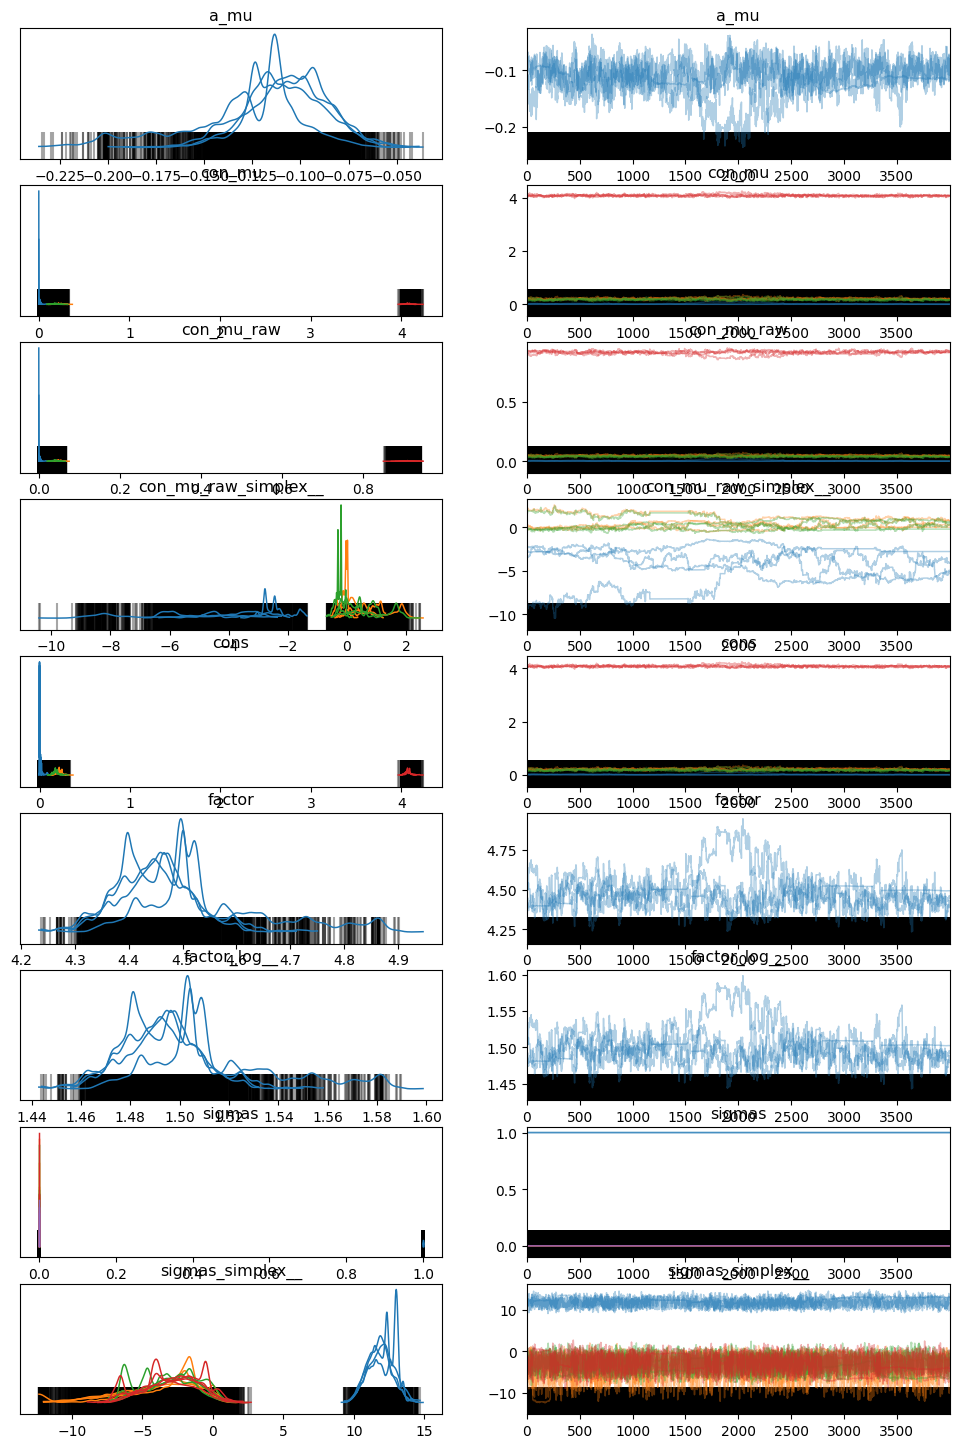

In [190]:
az.plot_trace(trace_nutpie,
              compact="true",
    chain_prop={"ls": "-"},)

# Model Selection via PPC
* see [Prior and Posterior Predictive Checks](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html)
* maybe [BART / Bayesian additive regression trees](https://www.pymc.io/projects/bart/en/latest/examples/bart_introduction.html) can enhance the modeling

In [19]:
with model0:
    idata = pm.sample_prior_predictive(draws=50)

Sampling: [a_mu, a_sigma, con_sigmas, cons, value]


In [21]:

az.plot_ppc(idata.posterior, num_pp_samples=100);

AttributeError: 'InferenceData' object has no attribute 'posterior'

In [22]:
idata.prior

<xarray.Dataset> Size: 3kB
Dimensions:           (chain: 1, draw: 50, con_sigmas_dim_0: 2, cons_dim_0: 2)
Coordinates:
  * chain             (chain) int32 4B 0
  * draw              (draw) int32 200B 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * con_sigmas_dim_0  (con_sigmas_dim_0) int32 8B 0 1
  * cons_dim_0        (cons_dim_0) int32 8B 0 1
Data variables:
    a_mu              (chain, draw) float64 400B -3.888 8.243 ... 1.139 10.28
    a_sigma           (chain, draw) float64 400B 0.3543 0.7871 ... 1.927 0.645
    con_sigmas        (chain, draw, con_sigmas_dim_0) float64 800B 0.8964 ......
    cons              (chain, draw, cons_dim_0) float64 800B -0.07385 ... 0.4735
Attributes:
    created_at:                 2024-09-20T05:13:44.670094+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2